In [24]:
from model.classification_model import ClassifierModel # class with classifiers
from model.reduce_model import ReduceModel # class with autoencoder

import numpy as np
import pandas as pd

from sklearn import metrics
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from plot_settings import * # plot configuration 

ide_plot() #plot for github dark theme

In [28]:
# Load main dataset
dataset = pd.read_csv("main_datasets/dataset.csv", index_col=0)
target = pd.read_csv("main_datasets/target.csv", index_col=0)

In [30]:
reduce_model = ReduceModel(model="AE", layers=(dataset.shape[1], 300, 10))
reduce_model.train(epochs=100, lr=1e-3)

100%|██████████| 100/100 [01:18<00:00,  1.28it/s]

Epoch 100, Train Loss: 0.0045105325177225266
Epoch 100, Validation Loss: 0.00476329650899226


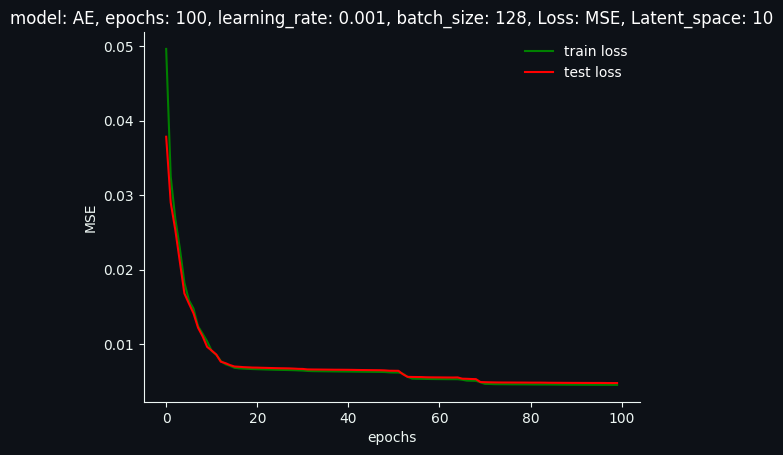

In [31]:
reduce_model.plot_loss()


In [32]:
main_reduced = reduce_model.transform(dataset)

In [33]:
qmof_reduced = reduce_model.transform(reduce_model.dataset.cpu())

In [37]:
main_reduced.shape

(102, 10)

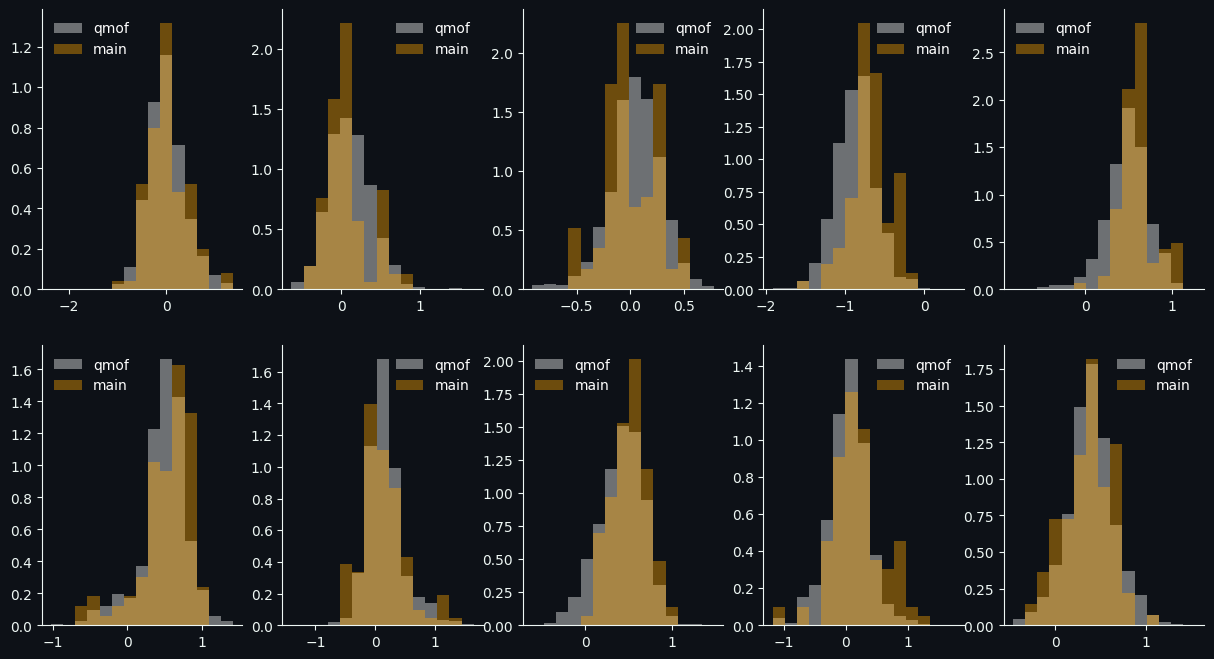

In [42]:
fig, axes = plt.subplots(2, 5, figsize=(15,8))
u = 0
for i in range(2):
    for h in range(5):
        v, bins, p = axes[i,h].hist(qmof_reduced[:, u], density=True, bins=15, alpha=0.4, label="qmof", color='w')
        axes[i,h].hist(main_reduced[:, u], density=True, bins=bins, alpha=0.4, label="main", color='orange')
        axes[i,h].legend()
        u += 1
        


In [40]:
# TODO: Тест Колмогорова - Смирнова на распределение признаков 
from scipy.stats import ks_2samp

for i in range(10):
    stats, p = ks_2samp(qmof_reduced[:,i], main_reduced[:,i])
    if p > 0.05:
        print(f'Распределения схожи {i} , {p}')
    else:
        print(f'Распределения различаются {i}, {p}')

Распределения схожи 0 , 0.2553704514251814
Распределения различаются 1, 0.0023485680036170317
Распределения различаются 2, 0.0011210503556129817
Распределения различаются 3, 5.359756814010882e-15
Распределения различаются 4, 6.175964876402081e-06
Распределения различаются 5, 0.0020262064320972794
Распределения различаются 6, 0.026259779932311572
Распределения различаются 7, 0.0012831176706807476
Распределения различаются 8, 0.00030663551685073304
Распределения схожи 9 , 0.36422997278293057


In [43]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer


def plot_2d(x1, y1, name):
    x1 = Normalizer().transform(x1)
    figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x1)

    pca = PCA(n_components=2, random_state=0)
    X_p = pca.fit_transform(x1)

    ax1.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='g', linewidth=1, alpha=0.8, label='0')
    ax1.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='r', linewidth=1, alpha=0.8, label='1')
    ax1.set_title(f"TSNE: {name}")

    ax2.scatter(X_p[np.where(y1 == 0), 0], X_p[np.where(y1 == 0), 1], marker='o', color='g', linewidth=1, alpha=0.8, label='0')
    ax2.scatter(X_p[np.where(y1 == 1), 0], X_p[np.where(y1 == 1), 1], marker='o', color='r', linewidth=1, alpha=0.8, label='1')
    ax2.set_title(f"PCA: {name}")
    ax2.legend()

def plot_2d_proba(x1, y1_proba, name):
    figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x1)

    pca = PCA(n_components=2, random_state=0)
    X_p = pca.fit_transform(x1)

    ax1.scatter(X_t[:, 0], X_t[:, 1], marker='o', color=y1_proba, linewidth=1, alpha=0.8, label='0')
    ax1.set_title(f"TSNE: {name}")

    ax2.scatter(X_p[:, 0], X_p[:, 1], marker='o', color=y1_proba, linewidth=1, alpha=0.8, label='0')
    ax2.set_title(f"PCA: {name}")
    ax2.legend()

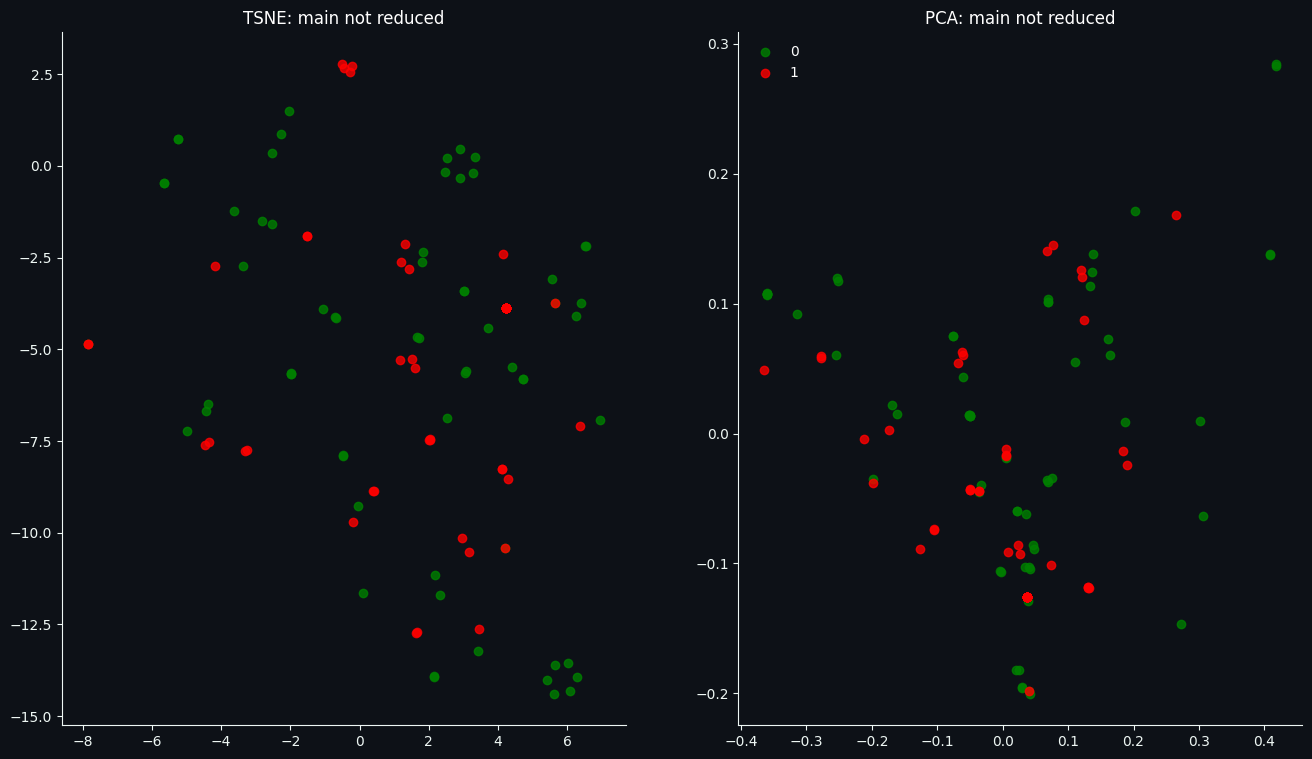

In [44]:
plot_2d(dataset.values, target, "main not reduced")

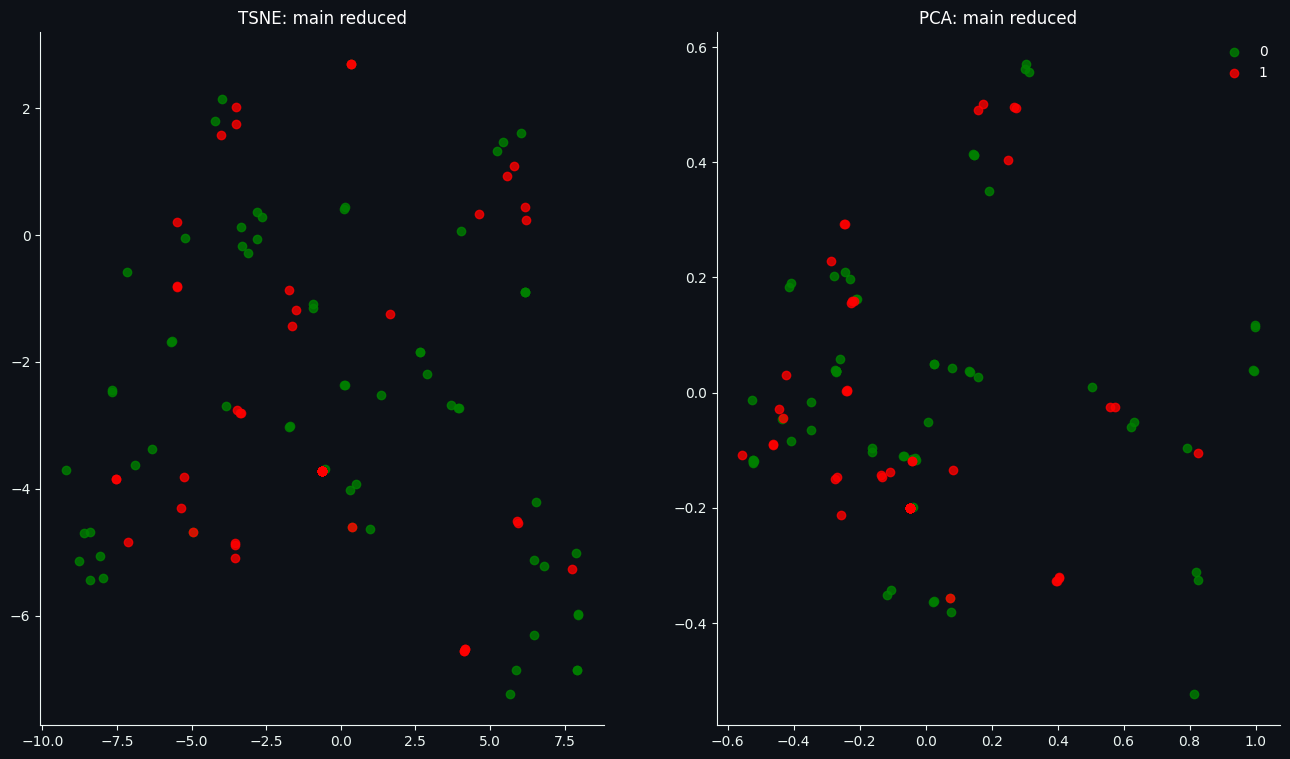

In [45]:
plot_2d(main_reduced, target, "main reduced")

In [47]:
plot_2d(reduce_model.dataset.cpu(), np.zeros((reduce_model.dataset.cpu().shape[0])), "qmof no reduce")

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

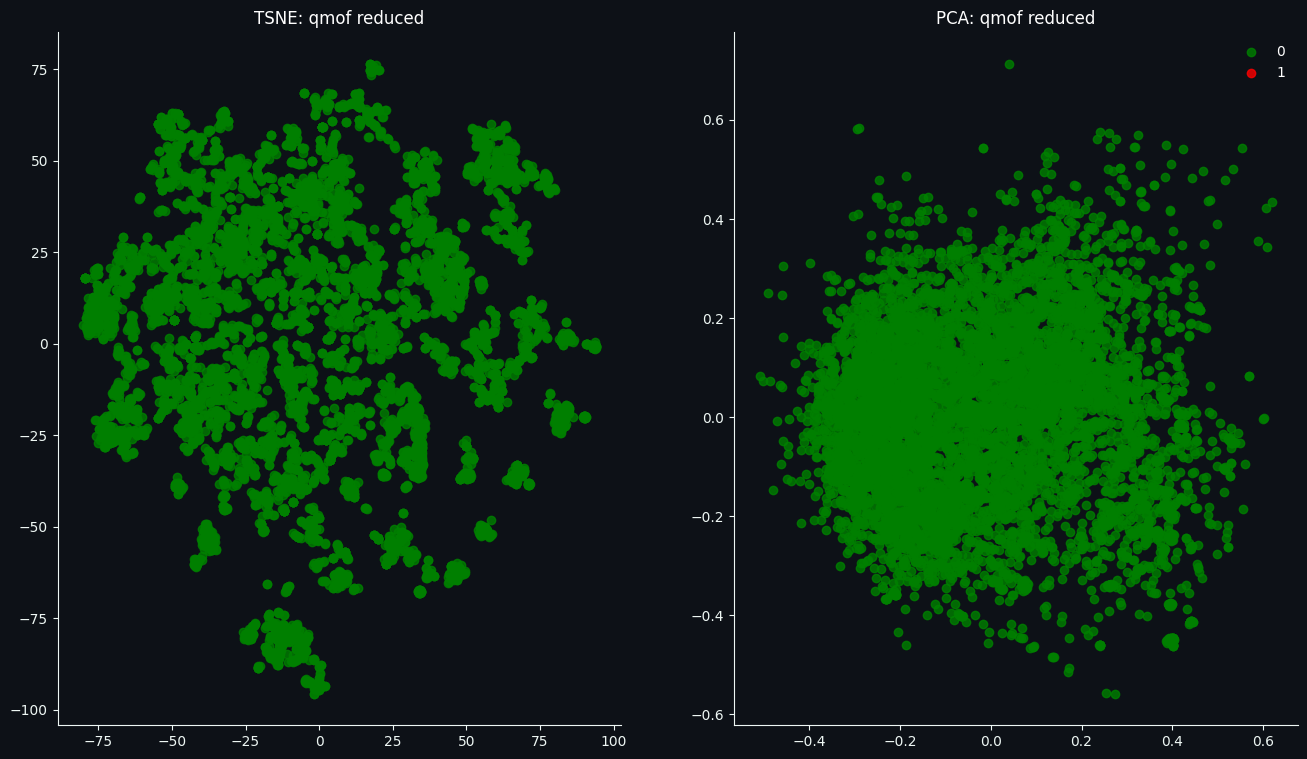

In [ ]:
plot_2d(qmof_reduced, np.zeros((qmof_reduced.shape[0],)), "qmof reduced")

# Classification

In [48]:
X_train, X_test, y_train, y_test = train_test_split(
    main_reduced, target.values.ravel(), test_size=0.2, random_state=42,
    stratify=target.values.ravel()
    )

scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
qmof_reduced_scaled = scaler.transform(qmof_reduced)

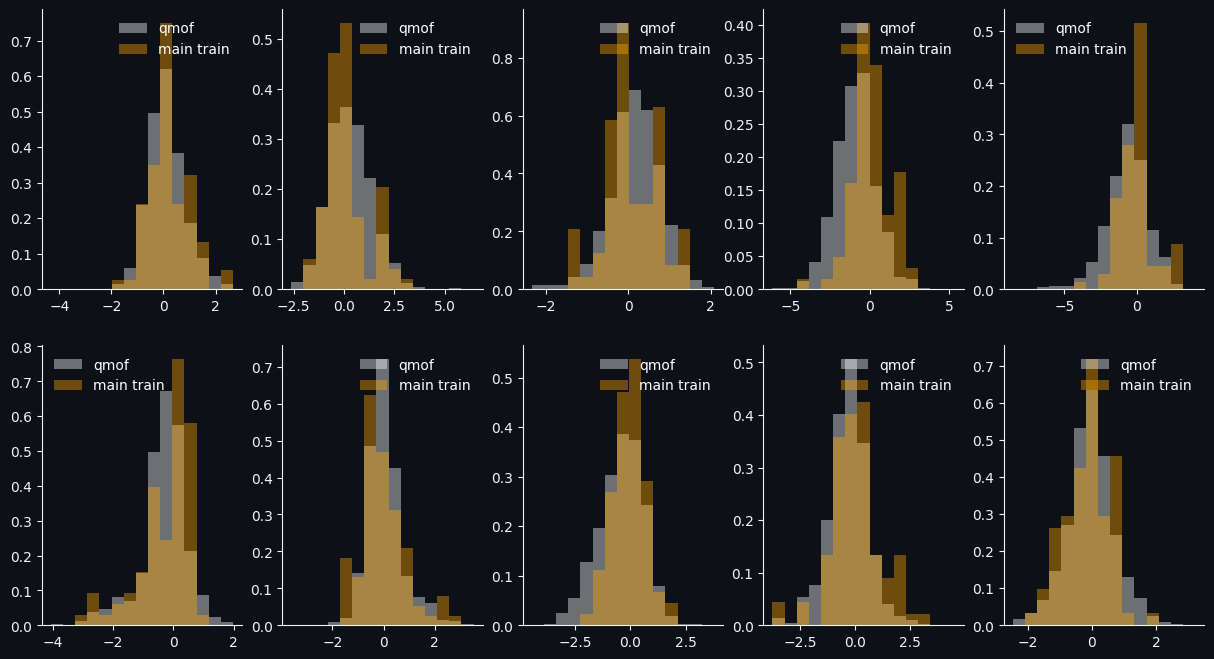

In [49]:
fig, axes = plt.subplots(2, 5, figsize=(15,8))
u=0
for i in range(2):
    for j in range(5):
        v, bins, p = axes[i,j].hist(qmof_reduced_scaled[:, u], density=True, bins=15, alpha=0.4, label="qmof", color='w')
        axes[i,j].hist(X_train[:, u], density=True, bins=bins, alpha=0.4, label="main train", color='orange')
        axes[i,j].legend()
        u+=1

In [50]:

for i in range(10):
    stats, p = ks_2samp(qmof_reduced_scaled[:,i], X_train[:,i])
    if p > 0.05:
        print(f'Распределения схожи {i} , {p}')
    else:
        print(f'Распределения различаются {i}, {p}')

Распределения схожи 0 , 0.3687035230312625
Распределения различаются 1, 0.004243846376531563
Распределения различаются 2, 0.013988924312344907
Распределения различаются 3, 8.812365586144015e-14
Распределения различаются 4, 0.00048037628557096235
Распределения различаются 5, 0.004038856251417935
Распределения различаются 6, 0.01931562147974302
Распределения различаются 7, 0.0005185309989387145
Распределения различаются 8, 0.0011968641923756438
Распределения схожи 9 , 0.5983399294346643


In [51]:
c_model = ClassifierModel()
res = c_model.cv(pd.DataFrame(X_train), pd.DataFrame(y_train), time_per_clf=10)

evaluate CatBoost
  0%|          | 22/9223372036854775807 [00:10<1193707760718149:58:24,  2.15trial/s, best loss: -0.8020833333333331]
evaluate LGM
  0%|          | 30/9223372036854775807 [00:10<861548866752236:30:56,  2.97trial/s, best loss: -0.25462962962962965]
evaluate XGB
  0%|          | 9/9223372036854775807 [00:10<3023516143876121:36:00,  1.18s/trial, best loss: -0.5501207729468599]
evaluate RF
  0%|          | 39/9223372036854775807 [00:10<665662680311945:31:44,  3.85trial/s, best loss: -0.6678571428571429] 
evaluate AdaBoost
  0%|          | 33/9223372036854775807 [00:10<804540571571219:12:00,  3.18trial/s, best loss: -0.7678571428571429] 


In [52]:
res

{'CatBoost': {'depth': 10,
  'l2_leaf_reg': 0.2878420775925252,
  'learning_rate': 0.00012683200191809603,
  'n_estimators': 31,
  'score': 0.8409090909090909,
  'balance': {'test': {'0.0': 10, '1.0': 6}, 'train': {'0.0': 42, '1.0': 23}}},
 'LGM': {'learning_rate': 1.3213302862707753e-05,
  'max_depth': 5,
  'n_estimators': 53,
  'reg_lambda': 0.8837501322634678,
  'subsample': 0.179820307253894,
  'score': 0.2884615384615385,
  'balance': {'test': {'0.0': 10, '1.0': 6}, 'train': {'0.0': 42, '1.0': 23}}},
 'XGB': {'learning_rate': 0.0002833742820575377,
  'max_depth': 8,
  'n_estimators': 21,
  'reg_lambda': 0.7882854315208924,
  'score': 0.7201426024955436,
  'balance': {'test': {'0.0': 11, '1.0': 6}, 'train': {'0.0': 41, '1.0': 23}}},
 'RF': {'max_depth': 13,
  'n_estimators': 61,
  'score': 0.6823529411764705,
  'balance': {'test': {'0.0': 11, '1.0': 6}, 'train': {'0.0': 41, '1.0': 23}}},
 'AdaBoost': {'learning_rate': 0.0007593415309702976,
  'max_depth': 4,
  'n_estimators': 74,
 

In [53]:
c_model.set_params({name: {param: res[name][param] for param in res[name] if param not in (
    "balance", "score")} for name in res})
c_model.fit(X_train, y_train)

In [54]:
for name in c_model.models:
    pred = c_model.models[name].predict(X_test)
    print(f"report for {name}: {c_model.score(y_test, pred):.2f}")
    print(metrics.classification_report(y_test, pred))

report for CatBoost: 0.71
              precision    recall  f1-score   support

         0.0       0.89      0.62      0.73        13
         1.0       0.58      0.88      0.70         8

    accuracy                           0.71        21
   macro avg       0.74      0.75      0.71        21
weighted avg       0.77      0.71      0.72        21

report for LGM: 0.29
              precision    recall  f1-score   support

         0.0       0.62      1.00      0.76        13
         1.0       0.00      0.00      0.00         8

    accuracy                           0.62        21
   macro avg       0.31      0.50      0.38        21
weighted avg       0.38      0.62      0.47        21

report for XGB: 0.60
              precision    recall  f1-score   support

         0.0       0.73      0.62      0.67        13
         1.0       0.50      0.62      0.56         8

    accuracy                           0.62        21
   macro avg       0.61      0.62      0.61        21
weight

c:\Users\v.shirobokov\.conda\envs\phase_trans_ML\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\v.shirobokov\.conda\envs\phase_trans_ML\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\v.shirobokov\.conda\envs\phase_trans_ML\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

In [55]:
def roc_auc_plot(clf_model: ClassifierModel, x_test, y_test):
    plt.figure()
    lw = 2
    plt.plot()
    for clf in clf_model.models:
        pred_proba = clf_model.models[clf].predict_proba(x_test)
        fpr, tpr, threshold = metrics.roc_curve(y_test, pred_proba[:,1])
        auc = metrics.auc(fpr, tpr)
        plt.plot(fpr,
                 tpr,
                 label=f"ROC curve {clf} (area={auc:.2f})")
    plt.plot([0, 1], [0, 1], color="orange", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic example")
    plt.legend(loc="lower right")
    plt.show()

def roc_auc_plot_one(clf: object, x_test, y_test):
    plt.figure()
    lw = 2
    plt.plot()
    pred_proba = clf.predict_proba(x_test)
    fpr, tpr, threshold = metrics.roc_curve(y_test, pred_proba[:,1])
    auc = metrics.auc(fpr, tpr)
    plt.plot(fpr,
             tpr,
             label=f"ROC curve: (area={auc:.2f})")
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic example")
    plt.legend(loc="lower right")
    plt.show()

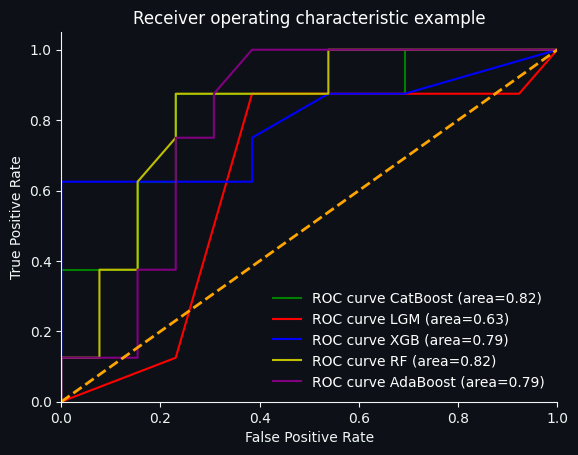

In [56]:
roc_auc_plot(c_model, X_test, y_test)

In [57]:
qmof_reduced = reduce_model.transform(reduce_model.dataset.cpu())

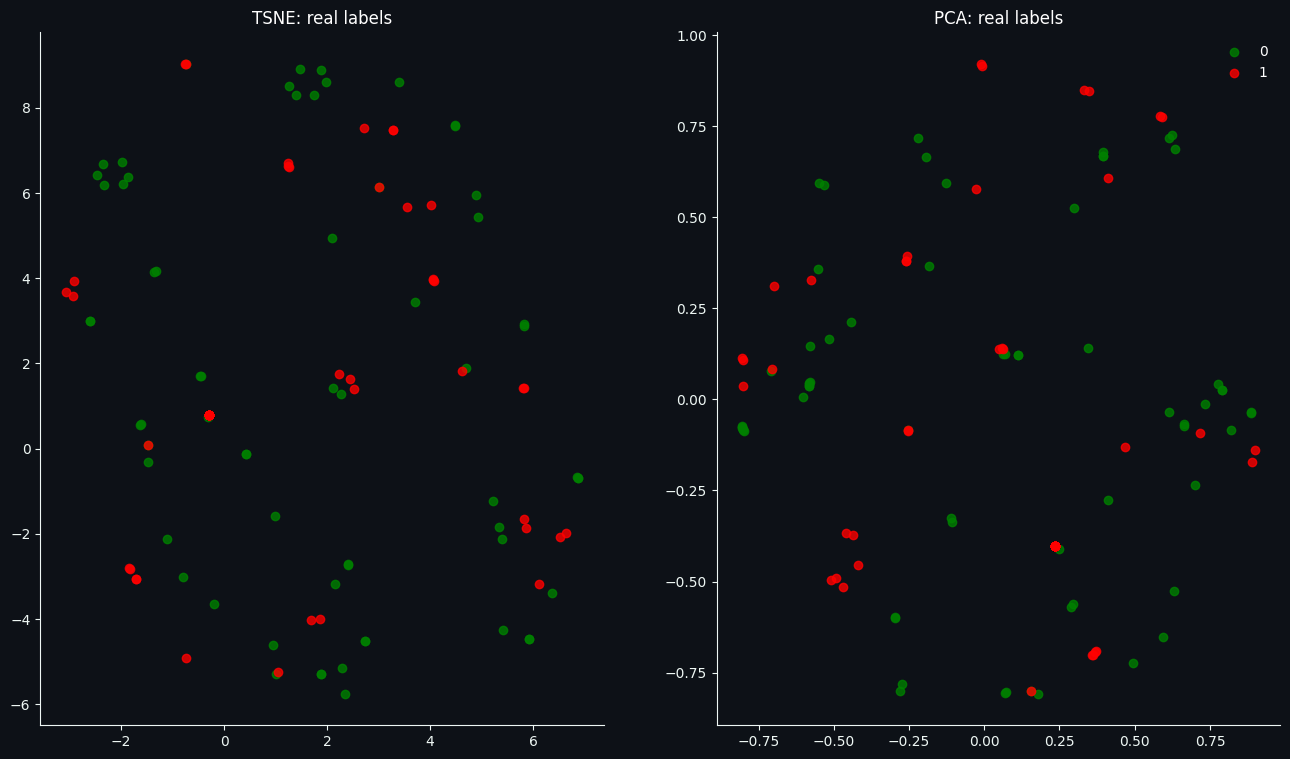

In [58]:
plot_2d(scaler.transform(main_reduced), target, "real labels")

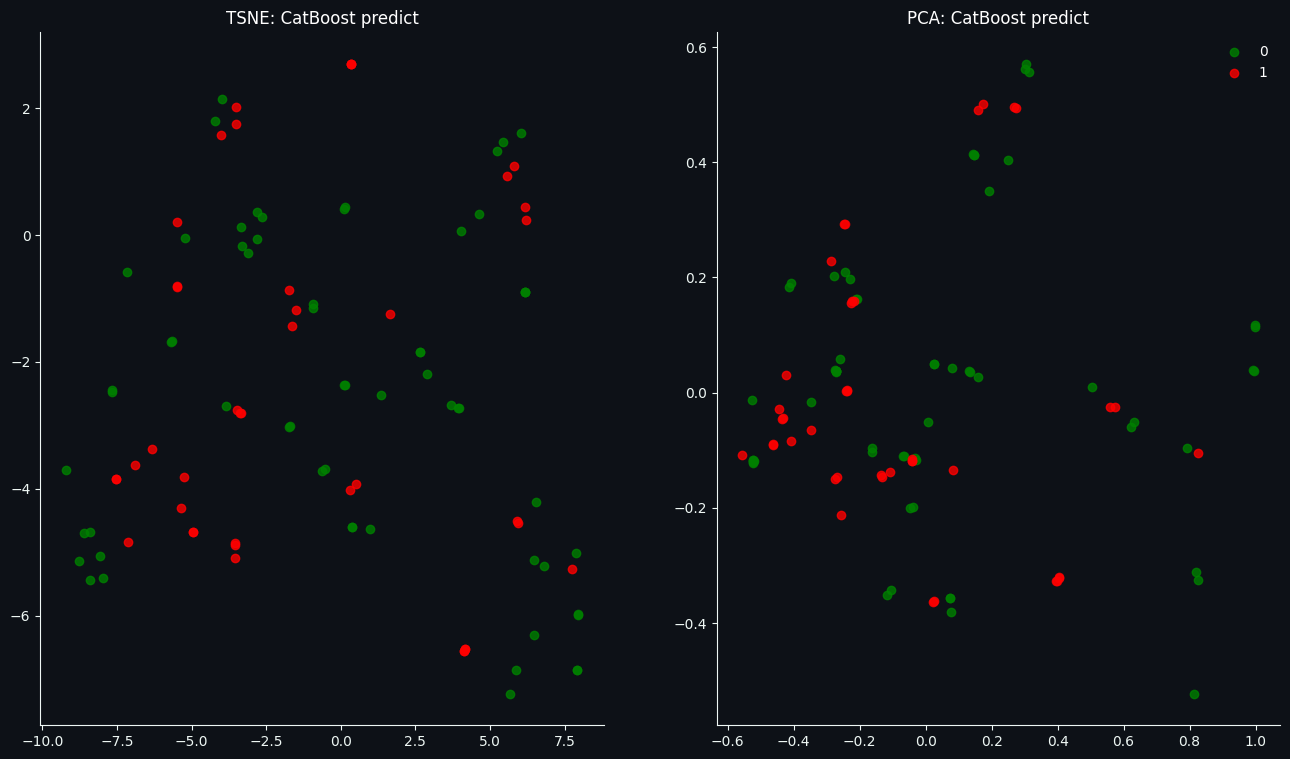

In [59]:
plot_2d(main_reduced, c_model.models["CatBoost"].predict(scaler.transform(main_reduced)), "CatBoost predict")

In [60]:
cat_ = np.array([*qmof_reduced, *main_reduced])

In [61]:
tsne = TSNE(n_components=2, random_state=0)
X_t = tsne.fit_transform(scaler.transform(cat_))
pca = PCA(n_components=2, random_state=0)
X_p = pca.fit_transform(scaler.transform(cat_))

In [62]:
xt_q = X_t[:qmof_reduced.shape[0]]
xp_q = X_p[:qmof_reduced.shape[0]]

xt_m = X_t[qmof_reduced.shape[0]:]
xp_m = X_p[qmof_reduced.shape[0]:]
pr_m = target.values.ravel()

In [63]:
pr_q = {name: c_model.models[name].predict_proba(qmof_reduced_scaled)[:,1] for name in c_model.models}

In [64]:
import matplotlib.cm as cm

In [65]:
def colormap_plot(name):
    color = cm.jet(pr_q[name])

    figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))

    ax1.scatter(xt_q[:, 0], xt_q[:, 1], marker='o', color=color, alpha=0.2)

    ax1.scatter(xt_m[pr_m == 0, 0], xt_m[pr_m == 0, 1], marker='x', color='g', alpha=0.1, label='0_main')
    ax1.scatter(xt_m[pr_m == 1, 0], xt_m[pr_m == 1, 1], marker='x', color='r', alpha=0.1, label='1_main')


    ax1.set_title(f"TSNE representation of predicted probability for {name}")
    ax2.scatter(xp_q[:, 0], xp_q[:, 1], marker='o', color=color, alpha=0.2)


    ax2.scatter(xp_m[pr_m == 0, 0], xp_m[pr_m == 0, 1], marker='x', color='g', alpha=0.1, label='0_main')
    ax2.scatter(xp_m[pr_m == 1, 0], xp_m[pr_m == 1, 1], marker='x', color='r', alpha=0.1, label='1_main')

    ax2.set_title(f"PCA representation of predicted probability for {name}")
    ax2.legend()


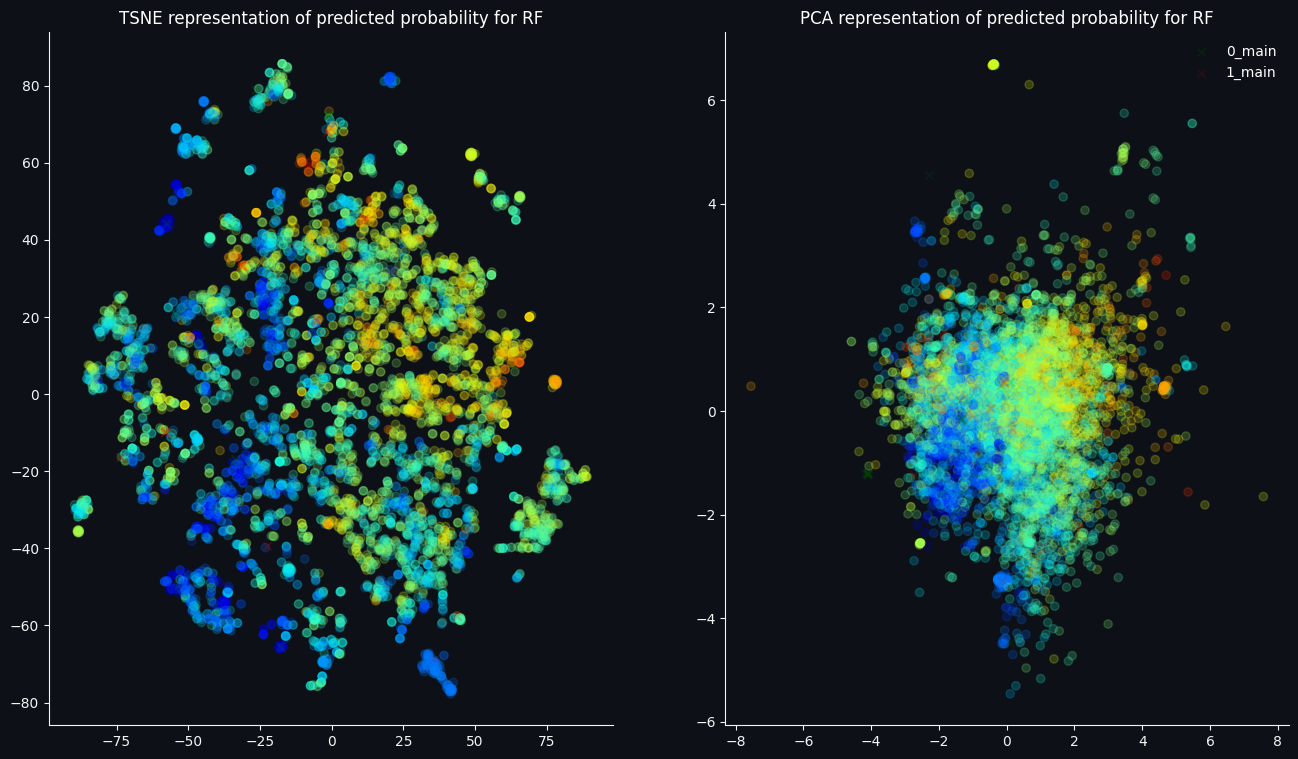

In [66]:
colormap_plot("RF")

In [67]:
colormap_plot("Knn")

KeyError: 'Knn'

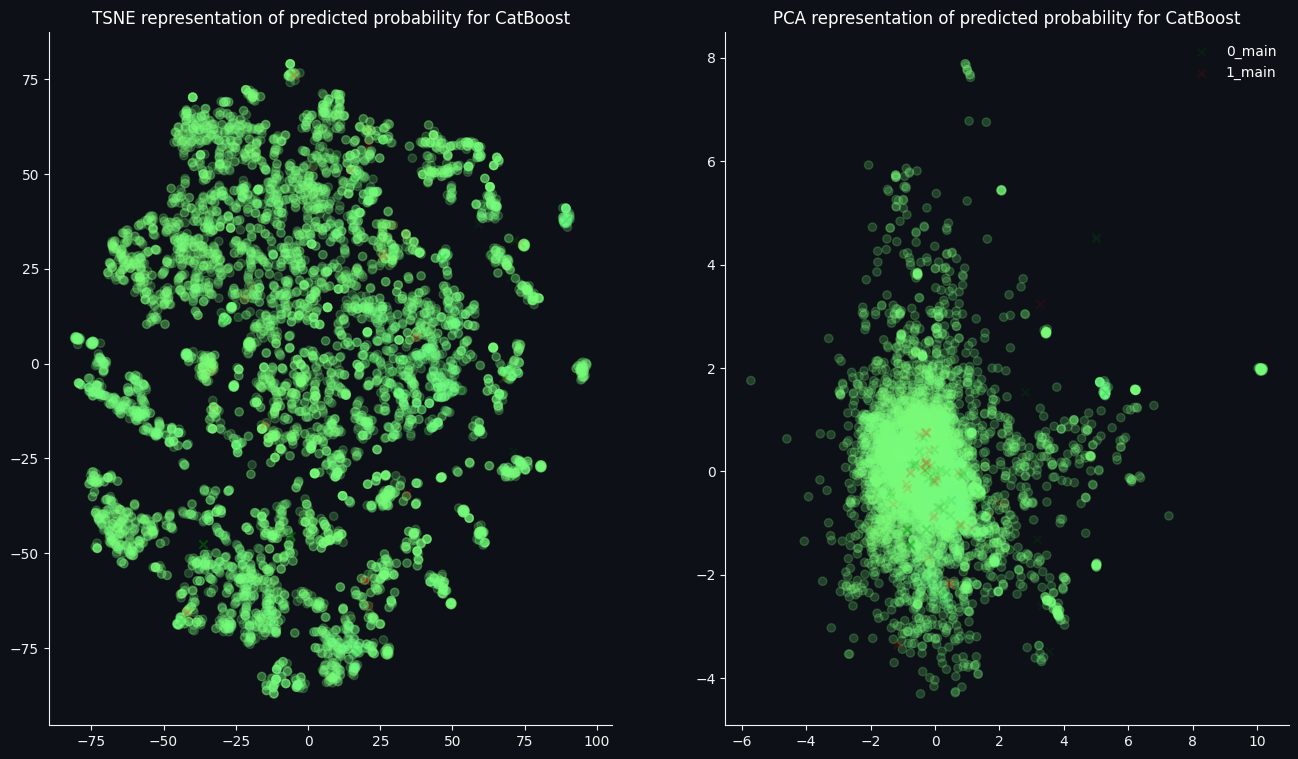

In [ ]:
colormap_plot("CatBoost")

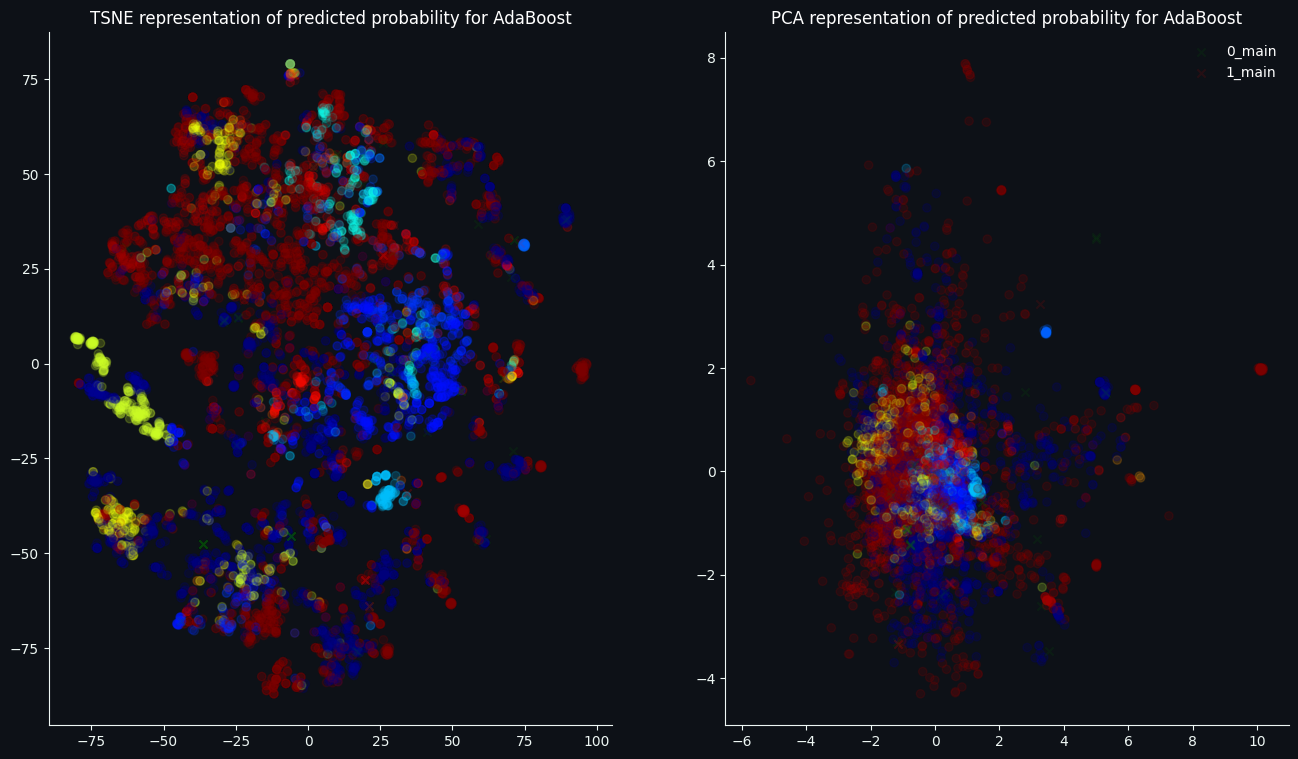

In [ ]:
colormap_plot("AdaBoost")

In [ ]:
import joblib

joblib.dump(reduce_model, "best/reduce_model.pkl")

joblib.dump(c_model, "best/c_model.pkl")

joblib.dump(res, "best/best_params.pkl")


['best/best_params.pkl']